In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import warnings
import sys
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error

data_base_dir = '../../../../datasets/Movielens/'
data_dir2 = data_base_dir + 'serendipity-sac2018/'
data_dir = data_base_dir + 'ml-20m/'
output_dir = data_dir + 'output2/'

genome_scores = data_dir + 'genome-scores.csv'
# genome_scores = data_dir + 'tag_genome.csv'
genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
ratings = data_dir + 'ratings.csv'
# ratings = data_dir + 'training.csv'
tags = data_dir + 'tags.csv'
# answers = data_dir + 'answers.csv'
genre_binary_terms = output_dir + 'movie_genre_binary_term_vector_df_bz2'
movies_lemmatized = output_dir + 'movies_lemmatized_genome_vector_df_bz2'

# data loading and preprocessing
target_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId',
                                                    values='relevance')
genome_scores_df = pd.DataFrame(pairwise_distances(target_df, metric='cosine'), index=target_df.index,
            columns=target_df.index)
del target_df

movies_with_genome = genome_scores_df.index.values
# movies_with_genome

movies_df = pd.read_csv(movies)
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df = movies_df[movies_df['movieId'].isin(movies_with_genome)]

all_movie_ids = movies_df['movieId'].unique()

ratings_df = pd.read_csv(ratings)
ratings_df = ratings_df[ratings_df['movieId'].isin(all_movie_ids)]
ratings_df = ratings_df.loc[:, ['userId', 'movieId', 'rating']]

all_user_ids = ratings_df['userId'].unique()

In [3]:
class ContentBased_Recommender:
    def __init__(self, term_vector_df, ratings_df, K=5, metric='cosine', weighted=True):
        self.term_vector_df = term_vector_df
        self.K = K
        self.ratings_df = ratings_df
        self.weighted = weighted

        # preprocessing and other calculations
        self.term_vector_df.fillna(0, inplace=True)
        self.movie_movie_distances = term_vector_df

    def get_mae_mse(self, user_id, candidate_movie_id, user_movies):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        # hide candidate movie from the user
        user_movies = np.setdiff1d(user_movies, candidate_movie_id)

        # load user rating for watched movies other than the candidate movie
        # user_ratings =
        users_all_ratings_df = ratings_df[ratings_df['userId'] == user_id]
        users_all_ratings_df = users_all_ratings_df[
            users_all_ratings_df['movieId'].isin(user_movies)]

        # load similarities to the candidate movie
        users_all_ratings_df['sim_candidate_movie'] = self.movie_movie_distances.loc[
            candidate_movie_id, users_all_ratings_df['movieId']].values

        mae, mse = self.predict_ratings_and_get_mae_mse(user_id, candidate_movie_id,
                                                        users_all_ratings_df)

        return mae, mse

    def predict_ratings_and_get_mae_mse(self, user_id, candidate_movie_id, users_all_ratings_df):
        user_ratings = users_all_ratings_df['rating'].values[:self.K]
        similarities = users_all_ratings_df['sim_candidate_movie'].values[:self.K]

        predicted_rating = 0
        if self.weighted:
            # weighted average
            predicted_rating = np.sum(user_ratings * similarities) / np.sum(similarities)
        else:
            # non-weighted average
            predicted_rating = np.sum(user_ratings) / len(user_ratings)

        actual_rating = self.ratings_df[(self.ratings_df['userId'] == user_id) & (
                self.ratings_df['movieId'] == candidate_movie_id)]['rating'].values[0]

        if np.isnan(predicted_rating):
            #             predicted_rating = 0
            predicted_rating = actual_rating

        mae = mean_absolute_error([actual_rating], [predicted_rating])
        mse = mean_squared_error([actual_rating], [predicted_rating])

        return mae, mse

    def get_average_mae_mse(self, user_id, user_movies):
        # movies watched by user
        #         if user_movies is None:
        #             user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        mae_list = list()
        mse_list = list()

        for candidate_movie_id in user_movies:
            mae, mse = self.get_mae_mse(user_id, candidate_movie_id, user_movies)

            mae_list.append(mae)
            mse_list.append(mse)

        return np.median(np.array(mae_list)), np.median(np.array(mse_list))

In [4]:
l1 = 'movies_lemmatized_threshold_'
l2 = '_float_movie_genomes_bz2'

# threshold_0.2_float_movie_genomes_bz2
l3 = 'threshold_'
l4 = '_float_movie_genomes_bz2'

thresholds = [0.25, 0.4, 0.7]
# thresholds = [0.25]

lemmatized_labels = [(l1 + str(x) + l2) for x in thresholds]
lemmatized_labels

full_labels = [(l3 + str(x) + l4) for x in thresholds]
full_labels

['threshold_0.25_float_movie_genomes_bz2',
 'threshold_0.4_float_movie_genomes_bz2',
 'threshold_0.7_float_movie_genomes_bz2']

In [5]:
# loading all required data
# user_full_genome_terms_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_bz2',
#                                            compression='bz2')
# user_full_genome_terms_gzip_df = pd.read_pickle(output_dir + 'user_full_genome_terms_df_gzip',
#                                                 compression='bz2')
lemmatized_thresholded_dfs = list()
full_thresholded_dfs = list()

metric='cosine'

for i, t in enumerate(thresholds):
    target_df = pd.read_pickle(output_dir + lemmatized_labels[i], compression='bz2')
    distances_df = pd.DataFrame(pairwise_distances(target_df, metric=metric), index=target_df.index,
            columns=target_df.index)
    del target_df    
    lemmatized_thresholded_dfs.append(distances_df)
    
    
    target_df = pd.read_pickle(output_dir + full_labels[i], compression='bz2')
    distances_df = pd.DataFrame(pairwise_distances(target_df, metric=metric), index=target_df.index,
            columns=target_df.index)
    del target_df
    full_thresholded_dfs.append(distances_df)

In [6]:
# load term vectors
target_df = pd.read_pickle(genre_binary_terms, compression='bz2')
genre_binary_terms_df = pd.DataFrame(pairwise_distances(target_df, metric=metric), index=target_df.index,
            columns=target_df.index)
del target_df

target_df = pd.read_pickle(movies_lemmatized, compression='bz2')
movies_lemmatized_df = pd.DataFrame(pairwise_distances(target_df, metric=metric), index=target_df.index,
            columns=target_df.index)
del target_df

global_user_id=0

In [7]:
count_df = ratings_df.groupby('userId').count()
count_df.describe()

,movieId,rating
count,138493.000000,138493.000000
mean,142.970453,142.970453
std,222.219438,222.219438
min,13.000000,13.000000
25%,34.000000,34.000000
50%,67.000000,67.000000
75%,154.000000,154.000000
max,6590.000000,6590.000000


In [8]:
# # divide user groups into 4 based on the number of movies watched by them
threshold1 = count_df['movieId'] <= 34
threshold2 = count_df['movieId'] <= 67
threshold3 = count_df['movieId'] <= 154
threshold4 = count_df['movieId'] > 154

user_group_1 = count_df[threshold1].index.values
user_group_2 = count_df[threshold2].index.values
user_group_3 = count_df[threshold3].index.values
user_group_4 = count_df[threshold4].index.values

user_group_2 = np.setdiff1d(user_group_2, user_group_1)
user_group_3 = np.setdiff1d(user_group_3, user_group_2)
user_group_4 = np.setdiff1d(user_group_4, user_group_3)

print(user_group_1.size)
print(user_group_2.size)
print(user_group_3.size)
print(user_group_4.size)

34763
34545
69462
34486


In [11]:
warnings.filterwarnings('ignore')

labels = ['genre_binary', 'genome_full', 'genome_lemmatized']
all_movie_ids = genre_binary_terms_df.index.values

def run(index, K, users_ndarray, start_range=0, end_range=None):
    print('running for K: %d' % K)
    if end_range is None:
        end_range = len(users_ndarray)
        
    #     for index, K in enumerate(K_ranges):
    genre_recommender = ContentBased_Recommender(genre_binary_terms_df, ratings_df, K,
                                                 metric='jaccard', weighted=True)
    genome_full_recommender = ContentBased_Recommender(genome_scores_df, ratings_df, K,
                                                       metric='cosine', weighted=True)
    genome_lemmatized_recommender = ContentBased_Recommender(movies_lemmatized_df, ratings_df, K,
                                                             metric='cosine', weighted=True)

    lemmatized_recommenders = list()
    full_recommenders = list()

    for i, t in enumerate(thresholds):
        full_recommenders.append(
            ContentBased_Recommender(full_thresholded_dfs[i], ratings_df, K, weighted=True))
        lemmatized_recommenders.append(
            ContentBased_Recommender(lemmatized_thresholded_dfs[i], ratings_df, K, weighted=True))

    # mae lists
    genre_mae_list = list()
    genome_full_mae_list = list()
    genome_lemmatized_mae_list = list()

    lemmatized_mae_list = list()
    full_mae_list = list()

    # mse lists
    genre_mse_list = list()
    genome_full_mse_list = list()
    genome_lemmatized_mse_list = list()

    lemmatized_mse_list = list()
    full_mse_list = list()

    for user_id in users_ndarray[start_range:end_range]:
        start_time = time()
        global_user_id = user_id
        print('user_id', user_id)

        # movies watched by user
        user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values

        if len(user_movies) <= 1:
            continue

        mae, mse = genre_recommender.get_average_mae_mse(user_id, user_movies)
        genre_mae_list.append(mae)
        genre_mse_list.append(mse)

        mae, mse = genome_full_recommender.get_average_mae_mse(user_id, user_movies)
        genome_full_mae_list.append(mae)
        genome_full_mse_list.append(mse)

        mae, mse = genome_lemmatized_recommender.get_average_mae_mse(user_id, user_movies)
        genome_lemmatized_mae_list.append(mae)
        genome_lemmatized_mse_list.append(mse)

        for i, t in enumerate(thresholds):
            mae, mse = full_recommenders[i].get_average_mae_mse(user_id, user_movies)
            full_mae_list.append(mae)
            full_mse_list.append(mse)

            mae, mse = lemmatized_recommenders[i].get_average_mae_mse(user_id, user_movies)
            lemmatized_mae_list.append(mae)
            lemmatized_mse_list.append(mse)

        finish_time = time() - start_time
        print("Total time taken for this user: %f seconds" % finish_time)

    mae_df = pd.DataFrame()
    mae_df['genre_MAE'] = genre_mae_list
    mae_df['genome_full_MAE'] = genome_full_mae_list
    mae_df['genome_lemmatized_MAE'] = genome_lemmatized_mae_list

    mse_df = pd.DataFrame()
    mse_df['genre_MSE'] = genre_mse_list
    mse_df['genome_full_MSE'] = genome_full_mse_list
    mse_df['genome_lemmatized_MSE'] = genome_lemmatized_mse_list

    for i, t in enumerate(thresholds):
        mae_df[full_labels[i] + '_MAE'] = full_mae_list[i]
        mse_df[full_labels[i] + '_MSE'] = full_mse_list[i]

        mae_df[lemmatized_labels[i] + '_MAE'] = lemmatized_mae_list[i]
        mse_df[lemmatized_labels[i] + '_MSE'] = lemmatized_mse_list[i]

    print("")
    mae_df.median().plot(kind='barh',
                         title='K=' + str(K) + ', avg MAE across all users, for all movies')
    plt.show()
    mse_df.median().plot(kind='barh',
                         title='K=' + str(K) + ', avg MSE across all users, for all movies')
    plt.show()


import multiprocessing as mp
import matplotlib.pyplot as plt

import threading as t

def run_parallel_for_users_range(users_ndarray, start_range, end_range, K_ranges):
    p_list = list()
    for index, K in enumerate(K_ranges):
#         p = mp.Process(target=run, args=(index, K, users_ndarray, start_range, end_range,))
        p = t.Thread(target=run, args=(index, K, users_ndarray, start_range, end_range,))
        p.start()
    
#     for p in p_list:
#         p.join()

    print("main process")

running for K: 5
main process
user_id 4
Total time taken for this user: 23.287486 seconds
user_id 6
Total time taken for this user: 21.020012 seconds
user_id 17
Total time taken for this user: 23.019423 seconds



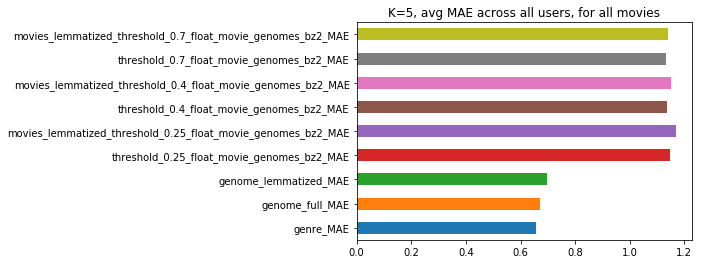

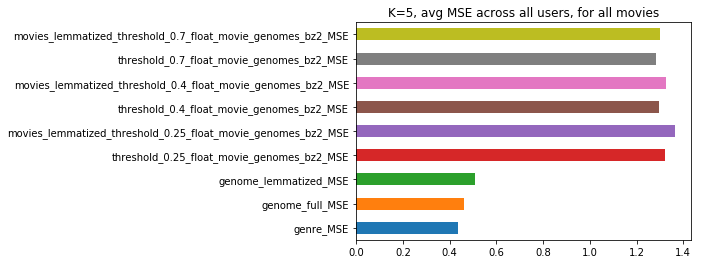

In [12]:
# K_ranges = [5, 10, 15, 20]
K_ranges = [5, 10]
start_range = 0
# end_range = len(all_answers_user_ids)
end_range = 3
run_parallel_for_users_range(user_group_1, start_range, end_range, K_ranges)

In [19]:
# user_id = 206808


# def print_progress():
#     sys.stdout.write('\rProgress %.2f%%' % ((np.where(user_group_1[:5] == global_user_id)[0][0]/(user_group_1[:5].size - 1)) * 100))
#     sys.stdout.flush()
    
# p_list = list()
# p = mp.Process(target=print_progress, args=())
# p_list.append(p)
# p.start()

# #     for p in p_list:
# #         # wait until all processes are finished
# #         p.join()

# print("main process\n")
print(global_user_id)
# np.where(user_group_1[:5] == global_user_id)
# sys.stdout.write('\rProgress %.2f%%' % ((np.where(user_group_1[:5] == global_user_id)[0][0]/(user_group_1[:5].size - 1)) * 100))

0
